# Spidercats: psychological safety and generative culture readout
Note: "Spidercats" is a fictional team-name used for the purpose of this example report.

# Introduction
In Nov 2020, we’ve measured two aspects of the work environment and culture in the Spidercats engineering team: (i) the degree of psychological safety; and (ii) the degree to which our culture can be considered “generative.” This document provides an overview of these concepts as well as the results of the surveys used to measure these.

## What is psychological safety and generative culture?
**Psychological safety** expresses the degree to which individuals on our team perceive the work environment as safe to take interpersonal risk, e.g., speaking up with non-confirmative opinions in meetings, asking questions, and asking for help. [Research by Amy Edmondson](https://www.amazon.com/Fearless-Organization-Psychological-Workplace-Innovation/dp/1119477247) as well as “[Project Aristotle](https://rework.withgoogle.com/print/guides/5721312655835136/)”, a large study from Google, has shown that a high degree of psychological safety is an important aspect of effective teams.

Related to this is the concept of a **generative culture** which was popularized by the [Accelerate book](https://www.amazon.com/Accelerate-Software-Performing-Technology-Organizations/dp/1942788339) and The “[State of DevOps](https://www.devops-research.com/research.html)” research reports. This model of culture considers culture as being on a spectrum ranging from “pathological” (power-oriented) to “bureaucratic” (rule-oriented) to “generative” (performance-oriented) cultures. In Accelerate it was shown that organizations with generative culture have higher levels of job satisfaction, as well as achieve higher levels of organizational performance (ability to deliver on the goals they set).

## The survey
We’ve measured the concepts of psychological safety and generative culture within the Spidercats team using a [set of valid and reliable survey questions](https://forms.gle/ByXsuvB614vopVVF7) taken from the research of Amy Edmondson (The Fearless Organization) and Forsgren et. al (Accelerate).

# Preparing the analysis
We'll use the [Edmondson library](https://github.com/krukow/edmondson/) for analyzing the survey results stored in a Google sheets document.

The following code block prepares the library for usage with our dataset.

In [37]:
(ns google-sheets-example
  (:require [edmondson.google-api :as api]
            [edmondson.survey-analysis :as analysis]
            [edmondson.survey-model :as model]
            [edmondson.config :as cfg]
            [edmondson.reports :as reports]
            [clojure.string :as str])
  (:use     [clojupyter.display :only (hiccup-html html latex markdown render-mime)]))
;

## Converting survey answers to quantitative data
The survey has four parts. There are two quantitative ("[psychometric](https://en.wikipedia.org/wiki/Psychometrics)") constructs: "Psychological safety", "Generative culture", and two qualitative, open-ended topics "Psychological safety domains", "Open-ended feedback".

For the quantitative constructs, we'll use a 7pt Likert scale for scoring each of the questions in the construct. 

The following snipplet defines the scales:

In [38]:
(def agree-disagree-7-pt-params ;; default scoring for 7pt Likert scale
  {"Strongly agree" 7
   "Agree" 6
   "Somewhat agree" 5
   "Neutral" 4
   "Somewhat disagree" 3
   "Disagree" 2
   "Strongly Disagree" 1})
;

This is the default score for each answer. However, for some questions Strongly agree is the "worst" answer and these are scored in reverse. The following two scoring functions represent the default scale and the negative (reverse scale).

In [39]:
(defn default-scale "identity scoring transformation" [a _] a)

(defn negative-scale
  "Scoring transform for reverse-scored likert questions"
  [a likert-scale]
  (- (inc (count likert-scale)) a))

;; Example
(let [answer "Strongly agree"
      default-score (get agree-disagree-7-pt-params answer)]
  (negative-scale default-score agree-disagree-7-pt-params))

1

## Defining a model of the survey
The survey model is an important concept in the Edmondson library. The model defines the "topics" being surveyed (sometimes called "constructs"). Each topic declares how it will be processed in the analysis (e.g. scored quantitatively).

For example, the "Psychological safety" construct declares: 
1. a name ("Psychological safety");
2. a unique set of survey question, e.g. "I am able to bring up problems and tough issues." (implicitly prefixed with "How much do you agree or disagree with the following statement(s)?");
3. a default scoring map (agree-disagree-7-pt-params) and a default scale (default-scale).
4. optionally, each question can override the defaults and state that it must be scored using another scale (e.g. "I worry that mistakes will be held against me." is scored with the `negative-scale` since "Strongly agree" is the worst possible answer to this question).

As you can see below, psychological safety and generative culture are scored using a 7-pt Likert scale with some questions reverse scored.

For "Psychological safety domains" and "Open-ended feedback" we don't do quantitative analysis. For these we simply gather peoples responses (the `:groups` and `:verbatims` keywords declare this, and the usage is explained later in this document).

In [40]:
(def example-model
  {
   "Psychological safety"
   {:scoring agree-disagree-7-pt-params ;; default scoring with 7p likert scale
    :scale default-scale ;; default scale is normal scale
    :questions [["I worry that mistakes will be held against me."
                 ;; since Strongly agree is quite bad here.
                 ;; this questions is scored in reverse, so we override default scale:
                 {:scale negative-scale}]
                "I am able to bring up problems and tough issues." ;; defaults
                ["People in the team sometimes reject others for being different."
                 {:scale negative-scale}]
                "It is safe to take a risk within the team."
                ["I find it difficult to ask other members of the team for help."
                 {:scale negative-scale}]
                "No one in the team would deliberately act in a way that undermines my efforts."
                "My unique skills and talents are valued and utilized in this team."]}

   "Generative culture"
   {:scoring agree-disagree-7-pt-params
    :scale default-scale
    :questions ["No-one is punished for delivering news of failure or other bad news."
                "Responsibilities are shared (you hear mostly \"this is our responsibility\" vs \"this is not my responsibility\")"
                "Cross functional and cross-team collaboration is encouraged and rewarded."
                "People on our team welcome new ideas, regardless of source and seniority."
                "Failure causes inquiry (failures are investigated, not ignored or hidden)"
                "Failures are treated primarily as opportunities to improve the system, processes or team."
                "New information is actively sought out."]}

   "Psychological safety domains"
   {:groups ["For you personally, choose the three topics which you find the most uncomfortable, or where you'd least want to bring up your concerns or have a conversation about."]}
   ;; This allows us to group responses based on how people check
   ;; boxes in this question. Also makes it easier to count which
   ;; boxes get the most checks.

   "Open-ended feedback"
   ;; These are not analyzed quantitatively
   {:verbatims ["If you could change one team process, or one thing about how the team works, what would you change and why?"
                "What is something the team does really well? Something that would make you very disappointed if the team stopped doing or something that makes you proud to be part of the team."]}

   })

(def model-index ;; generate an index of questions
  (model/index-questions example-model))

;; Example of using the model-index to easily looking up a question by it's unique identifier
(-> model-index
    (get "It is safe to take a risk within the team.")
    clojure.pprint/pprint);

{:scoring
 {"Strongly agree" 7,
  "Agree" 6,
  "Somewhat agree" 5,
  "Neutral" 4,
  "Somewhat disagree" 3,
  "Disagree" 2,
  "Strongly Disagree" 1},
 :scale #function[google-sheets-example/default-scale]}


## Fetch and score the responses
With the survey model declared, it is time to gather the responses and analyze them according to the survey model.

This code defines where we can find the survey results:

In [41]:
;; Assuming the survey results are stored in the Google sheet: 
;; https://docs.google.com/spreadsheets/d/1QkBeMNGfsHHga85c-UsLAwnpmz7QyhvFK_n31CzDe7c/edit?usp=sharing
;; which is connected automatically to the Google form.

;; Define where to find the results:
(def spreadsheetId "1QkBeMNGfsHHga85c-UsLAwnpmz7QyhvFK_n31CzDe7c")
(def tab-name "Form Responses 1")
(def spreadsheet-range (str tab-name "!B:R")) ;; this is where the answers are

;

Now let's fetch and score the responses using the Edmondson library helper functions:

*Note: This will take a bit of time to evaluate since it makes REST API calls the Google Sheets API.

(You may have to adjust the path to `credentials.json` and `tokens`; paths are relative to this notebook).

In [42]:
(binding [cfg/*credentials-json-path-override* "../../credentials.json"]
    (def survey-results 
        (api/eval-range {:token-directory "../../tokens"}
                        spreadsheetId 
                        spreadsheet-range)))

(def survey-questions (first survey-results)) ;; first row of sheet are the questions
(def survey-answers (rest survey-results)) ;; first row of sheet are the questions, the rest are the answers


(def normalized-responses
  (api/normalize-responses survey-questions survey-answers))

(def scored-responses (analysis/score-responses
                       model-index
                       normalized-responses))

;; Example of a scored response:
(->> scored-responses
     first
     (render-mime "application/json"))

## Now what?
We've done all of the following:
1. defined our survey model, 
2. fetched all the responses, 
3. scored each response according to the model. 

We've done all of this with a few lines of code with the help of the Edmondson library.

Next we'll perform a data analysis of the survey results, and summarize some key findings.

# The results: Psychological safety

## What is psychological safety and why is it important?
Psychological safety expresses the degree to which individuals on our team perceive the work environment as safe to take interpersonal risk, e.g., speaking up with non-confirmative opinions in meetings, asking questions, and asking for help. 

Psychological safety is critical for creating inclusive and diverse work environments. When people fear that they will be blamed or judged they protect themselves; after all it is safer to be quiet than to speak up. When psychological safety is lacking we may hesitate to disagree with leadership, point out a problem, or pretend that errors did not happen.

## Data analysis: Psychological safety
The Spidercats engineering team (including engineering managers but excluding eng. director) was surveyed in Nov 2020.

### Participation rate
We got the following results and participation rate:

In [43]:
(def total-team-size 22) ;; update this to reflect team size
(def num-responses (count scored-responses))
(def participation-rate (/ num-responses (float total-team-size)))
(printf "\nParticipation rate: %.1f%% (%d/%d respondents)" (* participation-rate 100) num-responses total-team-size);


Participation rate: 118.2% (26/22 respondents)

## Construct scoring
Psychological safety (PS) is scored using a 7pt Likert scale from “Strongly disagree – Strongly agree”.

Each question is scored between 1 and 7, where 1 is the worst possible answer and 7 is the best possible answer. (Sometimes “Strongly disagree” is the best possible answer.)

There are a total of 7 questions that are scored for PS, and these are summed up so each response is assigned a score between 7 and 49:

- The worst possible total score for a single response is 7
- The best possible total score for a single response is 49
- A score over 40 is considered very good.

When evaluating psychological safety for a group of people, we look at the distribution of scores for each respondent.

## Overall psychological safety scores

In [44]:
(def aggregate-results
  (analysis/aggregate-scores example-model scored-responses))

(def psych-safety-results (get aggregate-results "Psychological safety"))
(def mean-psych-safety (get-in psych-safety-results [:construct-stats :score-total]))

(hiccup-html 
    [:p 
     "The average psychological safety score is: "
     (reports/fmt-number mean-psych-safety)
     " (in the range [7,49])."
     ])

The average psychological safety score is: 32.9 (in the range [7,49]).

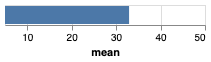

In [45]:
(render-mime "application/vnd.vegalite.v3+json" 
             {
                  :$schema "https://vega.github.io/schema/vega-lite/v4.json",
                  :data {:values [{:mean mean-psych-safety :good 40}]}
                  :mark {:type "bar"}
                  :encoding {
                    :x {:field :mean :type "quantitative" :scale {:domain [7 49]}}

                  }
                })

## Question breakdown
Across all the responses, on average, the **worst scoring questions were**:


In [46]:
(def ps-question-stats (get psych-safety-results :question-stats))
(defn ps-question->score [q] (get-in ps-question-stats [:question-stats q]))

(defn score->answer
    [score qid]
    (let [q-scores (:scoring (get model-index qid))
          scale (:scale (get model-index qid))
          scaled-score (scale score q-scores)]
        (some (fn [[answer qscore]] 
                  (when (= qscore scaled-score) answer)) 
              q-scores)))

(def worst-3-questions
    (->> (get ps-question-stats :worst-questions)
         (take 3)
         (map #(assoc (ps-question->score %) :id %))))

(defn render-question [qs]
    (let [mean (:score-mean qs)
          stddev (:score-stddev qs)
          cl (int (Math/ceil mean))
          cl-answer (score->answer cl (:id qs))
          fl (int (Math/floor mean))
          fl-answer (score->answer fl (:id qs))
          ]
     [:li "\"" (:id qs) "\"" 
      [:ul 
       [:li "Mean score: " (reports/fmt-number mean) " (stddev: " (reports/fmt-number stddev) ")."]
       [:li "which is between \"" fl-answer "/" fl "\" and \"" cl-answer "/" cl "\"."]]])
    )

(hiccup-html 
    [:ul (map render-question worst-3-questions)])


"I find it difficult to ask other members of the team for help." Mean score: 4.3 (stddev: 1.1). which is between "Neutral/4" and "Somewhat disagree/5". "No one in the team would deliberately act in a way that undermines my efforts." Mean score: 4.5 (stddev: 2.2). which is between "Neutral/4" and "Somewhat agree/5". "I worry that mistakes will be held against me." Mean score: 4.6 (stddev: 2.1). which is between "Neutral/4" and "Somewhat disagree/5".

Across the responses, on average, the **best scoring questions were**:

In [47]:
(def best-3-questions
    (->> (get ps-question-stats :best-questions)
         (take 3)
         (map #(assoc (ps-question->score %) :id %))))

(hiccup-html 
    [:ul (map render-question best-3-questions)])


"People in the team sometimes reject others for being different." Mean score: 5.1 (stddev: 1.6). which is between "Somewhat disagree/5" and "Disagree/6". "My unique skills and talents are valued and utilized in this team." Mean score: 4.9 (stddev: 1.2). which is between "Neutral/4" and "Somewhat agree/5". "I am able to bring up problems and tough issues." Mean score: 4.8 (stddev: 1.9). which is between "Neutral/4" and "Somewhat agree/5".

## Outliers
When analyzing psychological safety, it is important to look at outliers as well as averages: It is important that *everyone* on the team feel psychologically safe - if that is not the case, we cannot consider the environment fully inclusive, nor can we expect it to bring out the best in everyone on the team.


### PS-scores: the distribution
This is the distribution of PS scores (normalized to a 1-7 scale (as opposed to 7-49)).

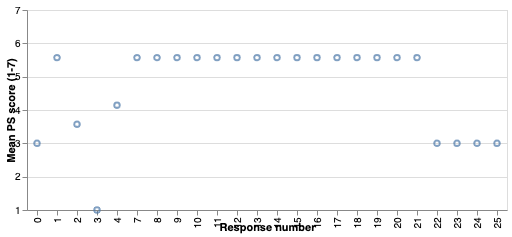

In [48]:
(def psych-safety-response-stats (get psych-safety-results :response-stats))
;;(render-mime "application/json" psych-safety-response-stats)

(render-mime "application/vnd.vegalite.v3+json" 
             {
                  :$schema "https://vega.github.io/schema/vega-lite/v4.json",
                  :description "Distribution of psych safety scores"
                  :data {:values (map-indexed (fn [i x] (assoc x :index i)) 
                                              (:response-mean-scores psych-safety-response-stats))}
                  :mark "point"
                  :encoding {
                    :y {:field :mean-score :type "quantitative" :scale {:domain [1 7]} :title "Mean PS score (1-7)"}
                    :x {:field :index :type "ordinal" :title "Response number"}
                  }
                })


As we can see, there are a people on the team who perceive the environment as less psychologically safe than others. The five worsts scores are:

In [49]:
(->> (get-in psych-safety-results [:response-stats :worst-scores])
     (take 5)
     (map :mean-score))

(1.0 3.0 3.0 3.0 3.0)

### Question breakdown for outliers
Let's do a breakdown of scores by question for this group scoring lowest on PS.

Across the five worst-scoring responses, the **worst scoring questions were**:

In [50]:
(def worst-5-outlier-responses (set (reports/take-outliers 5 :worst-scores psych-safety-results)))
(def worst-5-outlier-scored-responses (filter #(worst-5-outlier-responses (:responseId %)) scored-responses))

(def worst-5-outlier-psych-safety-results 
    (get (analysis/aggregate-scores example-model worst-5-outlier-scored-responses)
         "Psychological safety"))

(def worst-5-ps-question-stats (get worst-5-outlier-psych-safety-results :question-stats))
(defn worst-5-ps-question->score [q] (get-in worst-5-ps-question-stats [:question-stats q]))

(def worst-5-outliers-worst-3-questions
    (->> (get worst-5-ps-question-stats :worst-questions)
         (take 3)
         (map #(assoc (worst-5-ps-question->score %) :id %))))

(hiccup-html 
    [:ul (map render-question worst-5-outliers-worst-3-questions)])


"It is safe to take a risk within the team." Mean score: 1.0 (stddev: 0.0). which is between "Strongly Disagree/1" and "Strongly Disagree/1". "No one in the team would deliberately act in a way that undermines my efforts." Mean score: 1.0 (stddev: 0.0). which is between "Strongly Disagree/1" and "Strongly Disagree/1". "I worry that mistakes will be held against me." Mean score: 1.8 (stddev: 0.4). which is between "Strongly agree/1" and "Agree/2".

Across the five worst-scoring responses, the **best scoring questions were**:

In [51]:
(def worst-5-outliers-best-3-questions
    (->> (get worst-5-ps-question-stats :best-questions)
         (take 3)
         (map #(assoc (worst-5-ps-question->score %) :id %))))

(hiccup-html 
    [:ul (map render-question worst-5-outliers-best-3-questions)])


"My unique skills and talents are valued and utilized in this team." Mean score: 5.0 (stddev: 2.2). which is between "Somewhat agree/5" and "Somewhat agree/5". "I find it difficult to ask other members of the team for help." Mean score: 5.0 (stddev: 2.2). which is between "Somewhat disagree/5" and "Somewhat disagree/5". "People in the team sometimes reject others for being different." Mean score: 2.6 (stddev: 0.9). which is between "Agree/2" and "Somewhat agree/3".

# Psychological safety - domains
The degree of psychological safety in a situation can depend on the topic being discussed. It is possible that some topics are perceived as safe whereas others are considered unsafe. To better understand team sentiment, we asked each respondent to "... choose the three topics which you find the most uncomfortable, or where you'd least want to bring up your concerns or have a conversation about."

The participants picked among the following options:

In [55]:
(def domains-map   {"Giving or receiving critical feedback" :feedback
                    "Asking potentially dumb/newbie questions" :questions
                    "Disagreeing or voicing alternative opinions in team meetings" :meetings
                    "Disagreeing with specific people (\"oh, no one argues with them\")" :specific-people
                    "Rebalancing your workload (delegating or asking for support)" :workload
                    "Contributing as a more junior team member or one with different credentials" :credentials
                    "Understanding what it takes to get promoted (or why one person was promoted over another)" :promos
                    "Raising taboo topics (i.e., not up for discussion without invoking very strong pro or con feelings). Please specify the topic(s) under \"Other\"." :taboo})

(def domains-inverse-map (zipmap (vals domains-map) (keys domains-map)))

(def domains-question "For you personally, choose the three topics which you find the most uncomfortable, or where you'd least want to bring up your concerns or have a conversation about.")

(defn parse-domains [answer]
    (->> domains-map
         (map (fn [[a k]]                   
                  [k (.indexOf answer a)])) ;; find index of each possible answer
         (filter (fn [[k index]] (>= index 0)))
         (map first)))
    

(def domains-answers-counts 
    (->> scored-responses ;; all responses
        (map #(get-in % [:groups domains-question])) ;; get the responses to the domain-question
        (remove nil?)
        (map parse-domains) ;; [ (:a :b :c) (:a :b :d) (:d :e :f) ]
        (map frequencies) ;; [{:a 1 :b 1 :c 1} {:a 1 :b 1 :d 1} {:d 1 :e 1 :f 1}]
        (apply (partial merge-with +));; {:a 2 :b 2 :c 1 :d 1 :e 1 :f 1}
        (sort-by second) ;; ([:f 1] [:e 1] [:d 1] [:c 1] [:b 2] [:a 2])
        reverse))

(hiccup-html 
    [:ul (map (fn [[key count]]
                  [:li (get domains-inverse-map key) ": " count " votes."]
                  )
              domains-answers-counts)])



Asking potentially dumb/newbie questions: 22 votes. Giving or receiving critical feedback: 22 votes. Understanding what it takes to get promoted (or why one person was promoted over another): 17 votes. Disagreeing or voicing alternative opinions in team meetings: 5 votes. Contributing as a more junior team member or one with different credentials: 1 votes. Rebalancing your workload (delegating or asking for support): 1 votes. Disagreeing with specific people ("oh, no one argues with them"): 1 votes.


# Open-ended feedback
We also asked more open-ended questions, allowing people to provide verbatim responses. In these questions, we asked “If you could change one team process or one thing about how the team works, what would you change and why?” and “What is something the team does really well? Something that would make you very disappointed if the team stopped doing or something that makes you proud to be part of the team.”


### Q: "If you could change one team process, or one thing about how the team works, what would you change and why?"
Answers:

In [53]:
(def open-ended-verbatims (:verbatims (get aggregate-results "Open-ended feedback")))

(def could-be-improved (get open-ended-verbatims "If you could change one team process, or one thing about how the team works, what would you change and why?"))

(hiccup-html 
    [:ul (map #(do [:li "\"" % ".\""]) could-be-improved)])

"OKRs." "OKRs." "too much negativity." "Live demo." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs." "OKRs."

### Q: "If you could change one team process, or one thing about how the team works, what would you change and why?"
Answers:

In [54]:
(def working-well (get open-ended-verbatims "What is something the team does really well? Something that would make you very disappointed if the team stopped doing or something that makes you proud to be part of the team."))
(hiccup-html 
    [:ul (map #(do [:li "\"" % ".\""]) working-well)])



"Bonuses are great." "Social time is nice!." "we're really good at...." "if it crashes." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Social time is nice!." "Bonuses are great." "Bonuses are great." "Bonuses are great." "Bonuses are great."

# Have feedback?
Please send to @krukow / krukow@github.com